Antes de empezar, se recomienda la lectura de https://medium.com/analytics-vidhya/natural-language-processing-from-basics-to-using-rnn-and-lstm-ef6779e4ae66

En este caso de uso, se analizará el sentimiento implícito en una serie de reseñas de películas, haciendo uso del gran dataset de IMDB, disponible en el siguiente enlace: http://ai.stanford.edu/~amaas/data/sentiment/

Este conjunto de datos incluye ya reseñas etiquetadas como "negativas" o "positivas". También hay datos adicionales sin etiquetar para probar métodos de aprendizaje no supervisado. Para este caso de uso, descartamos los datos sin etiquetar.

# Setup

https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Bidirectional, Dense
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# Carga del dataset

El conjunto de datos de IMDB está asociado a una tarea de clasificación binaria, ya que cada reseña incluye un sentimiento positivo o negativo.

Para cargar los datos, usaremos esta función de keras: https://keras.io/api/preprocessing/text/

In [3]:
dataset, info = tfds.load('imdb_reviews', 
                          with_info=True,
                          as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteJ7Y0XS/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteJ7Y0XS/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteJ7Y0XS/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
dataset

{'test': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'train': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'unsupervised': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>}

In [17]:
train_dataset, test_dataset = dataset['train'], dataset['test']

In [18]:
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [19]:
for example, label in train_dataset.take(1):
  print('Texto: ', example.numpy())
  print('Etiqueta: ', label.numpy())

Texto:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Etiqueta:  0


# Preprocesamiento

## Reestructuración y optimización de rendimiento

En esta sección vamos a:
- Mezclar los datos para el entrenamiento 
- Crear lotes de pares (texto, etiqueta)
- Optimizar los lotes para un mejor rendimiento

Hay dos métodos importantes que se deben utilizar al cargar datos para mejorar el rendimiento de los lotes y asegurarse de que las I/O no se bloqueen:

- *cache()* mantiene los datos en la memoria después de que se carguen fuera del disco. Esto asegurará que el conjunto de datos no se convierta en un cuello de botella mientras se entrena el modelo. Si el conjunto de datos es demasiado grande para caber en la memoria, también se puede usar este método para crear una caché en disco de alto rendimiento, que es más eficiente de leer que muchos archivos pequeños.

- *prefetch()* superpone el preprocesamiento de datos y la ejecución del modelo durante el entrenamiento.

Se puede obtener más información sobre ambos métodos, así como sobre cómo almacenar en caché los datos en el disco, en la guía de rendimiento de datos: https://www.tensorflow.org/guide/data_performance

In [20]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [21]:
for example, label in train_dataset.take(1):
  print('Textos: ', example.numpy()[:3])
  print()
  print('Etiquetas: ', label.numpy()[:3])

Textos:  [b"Ah, I loved this movie. I think it had it all. It made me laugh out loud over a dozen of times. Yes, I am a girl, so I'm writing this from a girl's perspective. I think it's a shame it only scored 5.2 in rating. Too many guys voting? It was far above other romantic comedies. Just because I'm female I don't enjoy all chic flicks, on the contrary I prefer other genres. Romantic comedies tend to be shallow and not as funny as they meant to be. But like I said, this movie had it all, almost, in my opinion. Great script, good one-liners, fine acting. Although Eva Longoria Parker's character reminded very much of Gabrielle from Desperate Housewives, but so what? It was awesome. I will keep this film for rainy days, days when I feel low and need a few laughs."
 b'I think it took a lot of guts for her to come forward like that. It is unfortunate that when a celebrity suffers that is what helps people most. But, in her case, what she did was remarkable. I have been in the mental hea

In [27]:
# Guardamos un ejemplo y su etiqueta
for example, label in train_dataset.take(1):
  example = example.numpy()[0]
  label = label.numpy()[0]

print('Texto: ', example)
print()
print('Etiqueta: ', label)

Texto:  b"This is the story of a young woman seduced and then dumped by her older, married lover after she gets pregnant; she avenges herself against him, and his entire family, through black magic \xc2\x97\xc2\xa0which, disappointingly, she doesn't do herself but has someone else do for her. Good production values for a Thai horror flick. But the bland script never generates suspense, the director approaches the material entirely conventionally, and the final act loses viewer sympathy for the victims by throwing logic to the winds. At one point, a character has a prime opportunity to simply shoot the villainess dead, and instead she gets up and runs away without picking up the gun. Bad writing \xc2\x97 you're soaking in it! <br /><br />Some icky gore effects, including a really tasteless late-term-fetus corpse and one guy dying from having hundreds of live eels burst out of his stomach. Only recommended for genre completists who simply have to see every horror film produced in Asia in

### Estandarización y tokenización

https://www.tensorflow.org/text/tutorials/text_classification_rnn

A continuación, vamos a realizar las siguientes tareas de preprocesamiento:

- Estandarización
- Conversión a tokens
- Vectorización 

La estandarización se refiere al preprocesamiento del texto, generalmente para eliminar la puntuación o elementos HTML, con el fin de simplificar el conjunto de datos. La estandarización predeterminada convierte el texto a minúsculas y elimina la puntuación.

La tokenización se refiere a dividir cadenas en tokens (por ejemplo, dividir una oración en palabras individuales en base a espacios en blanco). El tokenizador predeterminado divide en base a espacios en blanco.

La vectorización se refiere a convertir tokens en números para que puedan introducirse en una red neuronal. El modo de vectorización predeterminado es int, lo cual genera índices enteros (uno por token). Este modo se puede utilizar para crear modelos que tengan en cuenta el orden de las palabras. También es posible utilizar otros modos, como el binario, para crear modelos de bolsa de palabras.

El método *TextVectorization* de Keras convierte cadenas de texto sin procesar en una representación codificada que puede ser leída por una capa *Embedding* o una capa densa.

In [28]:
# Usamos modo int (un índice por token)
vocab_size = 1000

encoder = TextVectorization(max_tokens= vocab_size, 
                            standardize= "lower_and_strip_punctuation",
                            split= "whitespace", 
                            ngrams=None, 
                            output_mode= "int",
                            output_sequence_length=None, 
                            pad_to_max_tokens=False, 
                            vocabulary=None)

A continuación, llamamos a *adapt* para ajustar el estado de la capa de preprocesamiento al conjunto de datos. Esto hará que el modelo cree un índice de cadenas a números enteros.

***Nota: es importante que solo se usen los datos de entrenamiento al llamar a adapt (usar el conjunto de prueba podría filtrar información).***

In [29]:
# Creamos un dataset formado únicamente por texto (sin etiquetas)
# Después, llamamos al método adapt
train_text = train_dataset.map(lambda text, labels: text)
encoder.adapt(train_text)

El método .adapt establece el vocabulario. Después del relleno y los tokens desconocidos, se ordenan por frecuencia:

In [30]:
# Mostramos los tokens del vocabulario
vocab = np.array(encoder.get_vocabulary())
vocab

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but',
       'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be',
       'one', 'its', 'at', 'all', 'by', 'an', 'they', 'from', 'who', 'so',
       'like', 'her', 'just', 'or', 'about', 'has', 'if', 'out', 'some',
       'there', 'what', 'good', 'when', 'more', 'very', 'even', 'she',
       'my', 'no', 'up', 'would', 'which', 'only', 'time', 'really',
       'story', 'their', 'were', 'had', 'see', 'can', 'me', 'than', 'we',
       'much', 'well', 'been', 'get', 'will', 'into', 'also', 'because',
       'other', 'do', 'people', 'bad', 'great', 'first', 'how', 'most',
       'him', 'dont', 'made', 'then', 'movies', 'make', 'films', 'could',
       'way', 'them', 'any', 'too', 'after', 'characters', 'think',
       'watch', 'two', 'many', 'being', 'seen', 'character', 'never',
       'little', 'acting', 'where', 'plot', 'best', 'love', 'did'

Una vez que se establece el vocabulario, se pueden codificar los textos en base a índices. Los tensores de los índices se rellenan con 0s en la secuencia más larga del lote (a menos que se establezca un output_sequence_length fijo):

In [32]:
example

b"This is the story of a young woman seduced and then dumped by her older, married lover after she gets pregnant; she avenges herself against him, and his entire family, through black magic \xc2\x97\xc2\xa0which, disappointingly, she doesn't do herself but has someone else do for her. Good production values for a Thai horror flick. But the bland script never generates suspense, the director approaches the material entirely conventionally, and the final act loses viewer sympathy for the victims by throwing logic to the winds. At one point, a character has a prime opportunity to simply shoot the villainess dead, and instead she gets up and runs away without picking up the gun. Bad writing \xc2\x97 you're soaking in it! <br /><br />Some icky gore effects, including a really tasteless late-term-fetus corpse and one guy dying from having hundreds of live eels burst out of his stomach. Only recommended for genre completists who simply have to see every horror film produced in Asia in the las

In [31]:
# Vamos a ver cómo queda el ejemplo codificado
encoded_example = encoder(example).numpy()
encoded_example

array([ 11,   7,   2,  64,   5,   4, 182, 246,   1,   3,  92,   1,  33,
        40, 897,   1,   1, 101,  55, 202,   1,  55,   1, 756, 416,  89,
         3,  25, 417, 222, 141, 323,   1,   1,   1,  55, 145,  82, 756,
        19,  44, 283, 329,  82,  16,  40,  50, 361,   1,  16,   4,   1,
       197, 519,  19,   2,   1, 225, 110,   1, 866,   2, 172,   1,   2,
       818,   1,   1,   3,   2, 464, 504,   1, 507,   1,  16,   2,   1,
        33,   1,   1,   6,   2,   1,  31,  29, 215,   4, 109,  44,   4,
         1,   1,   6, 316,   1,   2,   1, 358,   3, 297,  55, 202,  58,
         3,   1, 242, 201,   1,  58,   2,   1,  84, 485,   1, 320,   1,
         8,   9,  13,  13,  47,   1, 630, 303, 571,   4,  63,   1,   1,
         1,   3,  29, 230,   1,  36, 252,   1,   5, 421,   1,   1,  46,
         5,  25,   1,  61,   1,  16, 533,   1,  37, 316,  26,   6,  68,
       168, 197,  20,   1,   8,   1,   8,   2, 226,   1, 148])

In [35]:
# Si quisiésemos revertir esta codificación, no sería tarea fácil.
# Recordemos que hemos eliminado signos de puntuación y que, además,
# algunos tokens se han codificado como desconocidos
print("Original: ", example)
print()
print("Decodificado: ", " ".join(vocab[encoded_example]))

Original:  b"This is the story of a young woman seduced and then dumped by her older, married lover after she gets pregnant; she avenges herself against him, and his entire family, through black magic \xc2\x97\xc2\xa0which, disappointingly, she doesn't do herself but has someone else do for her. Good production values for a Thai horror flick. But the bland script never generates suspense, the director approaches the material entirely conventionally, and the final act loses viewer sympathy for the victims by throwing logic to the winds. At one point, a character has a prime opportunity to simply shoot the villainess dead, and instead she gets up and runs away without picking up the gun. Bad writing \xc2\x97 you're soaking in it! <br /><br />Some icky gore effects, including a really tasteless late-term-fetus corpse and one guy dying from having hundreds of live eels burst out of his stomach. Only recommended for genre completists who simply have to see every horror film produced in Asia

# Generación del modelo
Como parte de este modelo, se utilizará una capa *Embedding*. Por tanto, antes de proceder a la definición del modelo, vamos a explicar en qué consisten este tipo de capas.

## Embeddings

### Contexto

Dentro del NLP, son populares una serie de técnicas que permiten identificar similitudes entre palabras en función de su aparición conjunta en distintos fragmentos de texto.

La premisa en la que se basan estas técnicas es que es posible definir – o caracterizar – una palabra por el resto de palabras de las que aparezca acompañada.

Entre estas técnicas, destacan los modelos de *word embeddings*, que vinculan cada palabra o frase de un determinado corpus (conjunto de documentos) a un vector de números reales.

Como estos vectores representan coordenadas en un determinado espacio vectorial, podemos calcular palabras próximas, o análogas, en función de la distancia que exista entre sus vectores. Es decir, cuanto más cerca se encuentren dos vectores palabra, más similar será la semántica de dichas palabras. El cálculo de esta similitud o cercanía entre vectores puede hacerse de diversas maneras, siendo algunas de las más utilizadas la distancia euclídea o la similitud del coseno.

### Concepto
Técnicamente, un *embedding* es un espacio de dimensiones relativamente bajas al que se pueden trasladar vectores de dimensiones altas. 

Los embeddings permiten llevar a cabo el entrenamiento de un modelo con más facilidad en entradas de gran tamaño, como vectores *sparse* (con muchos ceros) que representan palabras. 

Idealmente, un embedding captura parte de la semántica de la entrada al colocar entradas similares (desde el punto de vista semántico) más cerca unas de otras en el espacio del embedding. Además, un embedding se puede aprender y volver a utilizar después en otros modelos.

Dicho de forma más simple, los embeddings en NLP, básicamente, permiten asignar un vector a cada palabra. Este vector guarda información semántica, lo que permite que pueda ser asociado o disociado a otros vectores (palabras) según distintos contextos gramaticales.

### Ejemplos
En la siguiente figura aparecen representados algunos vectores palabra y sus relaciones calculadas con GloVe, un modelo de word embeddings desarrollado por la Universidad de Stanford, el cual es capaz de capturar conceptos como que "hombre" es a "mujer" lo que "rey" es a "reina", relaciones entre verbos y tiempos verbales o vincular nombres de países con sus capitales.

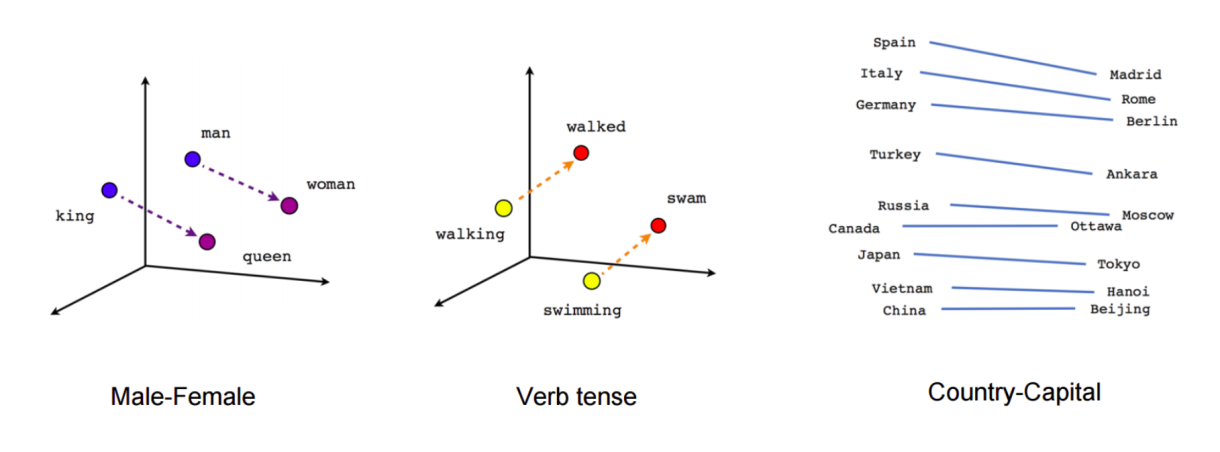

Además del mencionado GloVe, otros modelos populares de word embeddings son Word2Vec (Google) o fastText (Facebook).

En el siguiente enlace se muestra una visualización de las palabras más comunes en inglés y de las relaciones entre ellas, calculadas mediante Word2vec. En esta visualización se representan las palabras rodeadas de aquellas que en cuanto a su semántica son más similares: https://anvaka.github.io/pm/#/galaxy/word2vec-wiki?cx=899&cy=-9473&cz=681&lx=0.0644&ly=-0.7048&lz=0.0536&lw=0.7044&ml=300&s=1.75&l=1&v=d50_clean

Al tratar con problemas de PNL, podemos usar modelos de embeddings previamente entrenados como GloVe. Alternativamente, también podemos entrenar nuestros propios modelos de embeddings usando la capa *Embedding* de Keras.

### Necesidad de los modelos de embeddings

Como sabemos, al tratar con datos textuales, debemos convertirlos en números antes de incorporarlos a cualquier modelo de aprendizaje automático, incluidas las redes neuronales. 

Por simplicidad, las palabras se pueden comparar con variables categóricas. Usamos codificación one-hot para convertir variables categóricas en números. Para ello, creamos funciones ficticias para cada una de las categorías y las rellenamos con ceros y unos.

De manera similar, si usamos la codificación one-hot en palabras de datos textuales, tendremos una característica ficticia para cada palabra, lo que se traduce en 10.000 características para un vocabulario de 10.000 palabras. Este no es un enfoque de embedding factible, ya que requiere un gran espacio de almacenamiento para los vectores de palabras y reduce la eficiencia del modelo.

La capa de embedding nos permite convertir cada palabra en un vector de longitud fija de tamaño definido. El vector resultante es denso y tiene valores reales en lugar de solo 0s y 1s. Además, la longitud fija de los vectores de palabras nos ayuda a representar las palabras de una mejor manera y con dimensiones reducidas.

De esta forma, la capa de embedding funciona como una tabla de búsqueda. Las palabras son las claves en esta tabla, mientras que los vectores de palabras densas son los valores. 

Ejercicio recomendado: https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce

## Definición de la arquitectura

### Modelo 1 (LSTM simple)

In [49]:
model1 = Sequential([
    encoder,
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        # Usamos masking para poder procesar secuencias de distintos tamaños
        mask_zero=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1)
])

### Modelo 2 (LSTM bidireccional)

Se va a definir y utilizar la siguiente arquitectura:

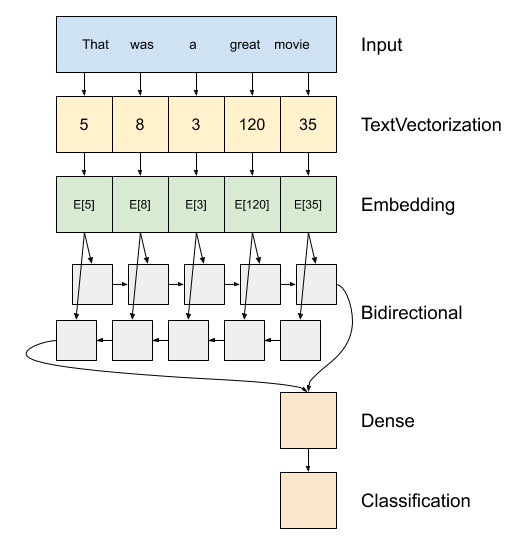

Vamos a analizarlo con más detalle:
- La primera capa es el *encoder* (TextVectorization), que convierte el texto en una secuencia de índices de tokens.
- Después del encoder, se añade una capa de *embedding*, que almacena un vector por palabra. Cuando se hace referencia a ella, convierte las secuencias de índices de palabras en secuencias de vectores, los cuales se pueden entrenar. Tras el entrenamiento, las palabras con significados similares suelen tener vectores similares.
- Los LSTM bidireccionales son una extensión de los LSTM tradicionales que pueden mejorar el rendimiento del modelo en problemas de clasificación de secuencias (consultar https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/). 
    - La principal ventaja de una RNN bidireccional es que la señal desde el principio de la entrada no necesita procesarse hasta el final en cada paso de tiempo para modificar la salida.
    - La principal desventaja de una RNN bidireccional es que no puede transmitir predicciones de manera eficiente a medida que se agregan palabras al final.
- Una vez que la RNN ha convertido la secuencia en un solo vector, las dos capas de tipo *Dense* realizan un procesamiento final y convierten esta representación vectorial en una sola salida como resultado de la clasificación.


In [36]:
model2 = Sequential([
    encoder,
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        # Usamos masking para poder procesar secuencias de distintos tamaños
        mask_zero=True),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(1)
])

## Compilación

In [50]:
model1.compile(loss= BinaryCrossentropy(from_logits=True),
              optimizer=Adam(),
              metrics=['accuracy']) 

In [ ]:
model2.compile(loss= BinaryCrossentropy(from_logits=True),
              optimizer=Adam(),
              metrics=['accuracy']) 

## Entrenamiento

In [51]:
history1 = model1.fit(train_dataset, 
                    epochs= 2,
                    validation_data= test_dataset)

Epoch 1/2
391/391 [==============================] - 340s 828ms/step - loss: 0.4907 - accuracy: 0.7466 - val_loss: 0.3672 - val_accuracy: 0.8450
Epoch 2/2
391/391 [==============================] - 321s 822ms/step - loss: 0.3584 - accuracy: 0.8467 - val_loss: 0.3451 - val_accuracy: 0.8526


In [ ]:
history2 = model2.fit(train_dataset, 
                    epochs= 2,
                    validation_data= test_dataset)

# Evaluación del modelo

In [52]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 60s 152ms/step - loss: 0.3451 - accuracy: 0.8526
Test Loss: 0.3451407849788666
Test Accuracy: 0.8525999784469604


(0.0, 0.3720204994082451)

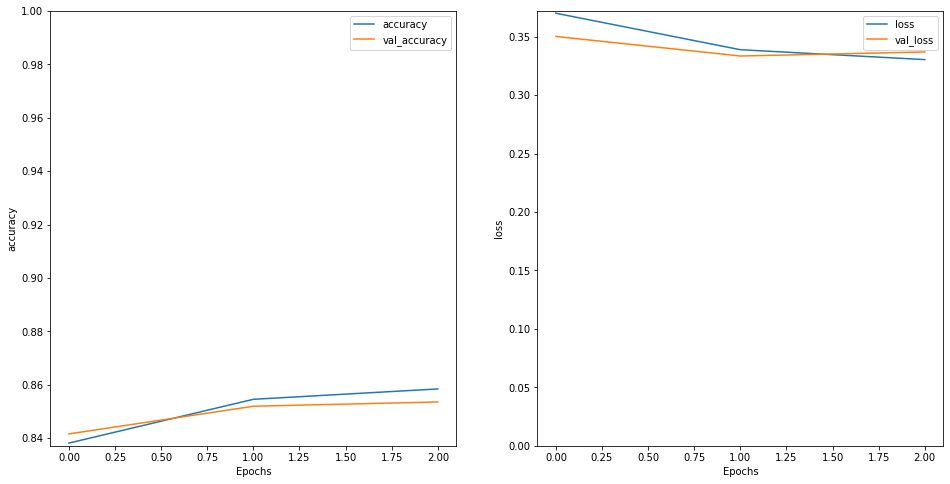

In [46]:
metric = 'accuracy'

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)

plt.plot(history.history[metric])
plt.plot(history.history['val_' + metric], '')
plt.xlabel("Epochs")
plt.ylabel(metric)
plt.legend([metric, 'val_'+metric])

plt.ylim(None, 1)
plt.subplot(1, 2, 2)

plt.plot(history.history["loss"])
plt.plot(history.history['val_' + "loss"], '')
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(["loss", 'val_'+"loss"])

plt.ylim(0, None)

Vamos a generar una predicción para una nueva oración. Si la predicción es >=0.0, se considerará que el sentimiento es positivo. De lo contrario, será negativo.

In [48]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

array([[0.5368221]], dtype=float32)